# RL homework 3

-------------------------------


**Name:** Sahil Shah

**SN:** 20194624

-----------------------------------


**Due date:** *10th May, 2021, 4:00 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw3.ipynb** before the deadline above.

# The Assignment

### Objectives

#### Part 1:
You will implement several algorithms to investigate the role of planning in reinforcement learning.

#### Part 2:
You will be guided through the implementation of a full deep reinforcement learning agent.

#### Part 3:
You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.



# Setup

Run all the cells in this section, but do not modify them.

## Imports

In [ ]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Gridworlds

In [ ]:
#@title Implementation
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap="YlOrRd_r")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-3):
      plt.plot([+0.5, w-1.5], [y+1.5, y+1.5], '-k', lw=2, alpha=0.5)
    for x in range(w-3):
      plt.plot([x+1.5, x+1.5], [+0.5, h-1.5], '-k', lw=2, alpha=0.5)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()
  
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

A grid world


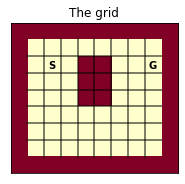


An alternative grid world


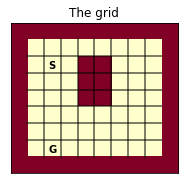


Features (visualised as 9x9 heatmaps) for different locations in the grid
(Note: includes unreachable states that coincide with walls in this visualisation.)


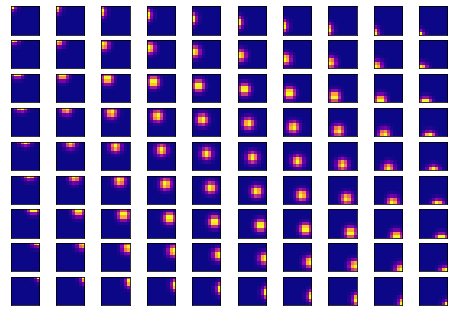

In [ ]:
#@title Show gridworlds

# Plot tabular environments
grid = Grid()
alt_grid = AltGrid()
print("A grid world")
grid.plot_grid()
plt.show()
print("\nAn alternative grid world")
alt_grid.plot_grid()
plt.show()

# Plot features of each state for non tabular version of the environment.
print(
    "\nFeatures (visualised as 9x9 heatmaps) for different locations in the grid"
    "\n(Note: includes unreachable states that coincide with walls in this visualisation.)"
)
feat_grid = FeatureGrid()
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)),
            interpolation='nearest',
            cmap='plasma')
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

## Helpers

In [ ]:
#@title helper functions (run, but don't modify this cell)

def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

# Part 1: Planning [35 marks]

## 1.1: Implement Models

### Q 1.1.1 [3 marks]

Implement a trainable **tabular model** of the environment.

The model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model predictions.

Given that the environment is deterministic and tabular the model will reduce to a simple lookup table.

In [ ]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self.states = np.zeros((number_of_states, number_of_actions))
    self.rewards = np.zeros((number_of_states, number_of_actions))
    self.discounts = np.zeros((number_of_states, number_of_actions))

  def next_state(self, s, a):
    return self.states[s,a]
  
  def reward(self, s, a):
    return self.rewards[s,a]

  def discount(self, s, a):
    return self.discounts[s,a]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    self.states[state, action] = next_state
    self.rewards[state, action] = reward
    self.discounts[state, action] = discount

### Q 1.1.2 [3 marks]

Implement a trainable **linear model** of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward $r'$, discount $\gamma'$ and next state $\mathbf{s}'$ will all be a linear function of the current state $\mathbf{s}$.
* $\mathbf{s}' = \mathbf{M}_a \mathbf{s}$
* $r' = (\mathbf{m}^r_a)^{\top} \mathbf{s}$
* $\gamma' = (\mathbf{m}^{\gamma}_a)^{\top} \mathbf{s}$

Where $\mathbf{M}_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $\mathbf{m}^r_a$ and $\mathbf{m}^{\gamma}_a$ are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by stochastic gradient descent. 

Write down the update to the parameters of the models and implement the update in the model below.


In [ ]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self.M_a = np.zeros((number_of_actions, number_of_features, number_of_features))
    self.m_r = np.zeros((number_of_actions, number_of_features))
    self.m_gamma = np.zeros((number_of_actions, number_of_features))

  def next_state(self, s, a):
    return self.M_a[a]@s
  
  def reward(self, s, a):
    return self.m_r[a]@s

  def discount(self, s, a):
    return self.m_gamma[a]@s

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    self.M_a[action] -= step_size * -np.outer(next_state - self.M_a[action]@state, state)
    self.m_r[action] -= step_size * -state * (reward - self.m_r[action]@state)
    self.m_gamma[action] -= step_size * -state * (discount - self.m_gamma[action]@state)

## 1.2: Implement Agents

We are going to implement 4 agent:
- Tabular Q-learning with Experience Replay
- Tabular Dyna-Q with a tabular model
- Linear Q-learning with Experience Replay
- Linear Dyna-Q with a linear model

All agents you implement in this section must share the agent interface below:

#### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get such initial observation by instatiating an environment (e.g., `grid = Grid()`), and then calling `grid.get_obs()`.

#### `step(self, reward, discount, next_observation)`:
The step should update the internal values, and return a new action to take. When the discount is zero ($\text{discount} = \gamma = 0$), the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function. Note that to perform updates within the `step` function you typically need to store the previous state and/or action: you may set such previous action to 0 in the constructor for consumption in the first step of the first episode of the agent's lifetime.
 
#### `q_values()`:
For tabular agents **only**. This method must return a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

#### `q_values(state)`:
For agents with function approximation **only**. This method must return an array of Q values of shape: (`number_of_actions`)


### Q 1.2.1 [3 marks]

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate each observed transition *(s, a, r, g, s')* in a *replay buffer*,
* apply an online Q-learning update with the most recently observed transition,
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

So, the `step` function of the agent will, conceptually, look as follows:

1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ 

1. Loop repeat n times:

  1. Sample $S, A, R, \gamma, S'$ from replay
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [ ]:
 class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._state = initial_state
    self._action = 0
    self._step_size = step_size
    self._replay = []
    self._q = np.zeros((number_of_states, number_of_actions))
    self._n = num_offline_updates
    self._behaviour_policy = behaviour_policy


    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self._replay.append((s, a, r, g, next_s))
    self._q[s, a] += self._step_size*(r + g*np.max(self._q[next_s]) - self._q[s,a])
    for i in range(self._n):
      idx = np.random.randint(len(self._replay))
      (S,A,R,G,next_S) = self._replay[idx]
      self._q[S, A] += self._step_size*(R + G*np.max(self._q[next_S]) - self._q[S,A])
    self._action = self._behaviour_policy(self._q[next_s])
    self._state = next_s
    return self._action


### Q 1.2.2 [3 marks]

Implement an agent that uses **Dyna-Q** to learn action values.
* select actions randomly
* accumulate all observed transitions *(s, a)* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

So, the `step` function conceptually looks as follows:
1. Append most recent observed transition $(S_t, A_t)$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Update model: $M(S_t, A_t)$, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Loop repeat n times:

  1. Sample $S, A$ from replay
  
  1. Generate $R, \gamma, S' = M(S, A)$
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [ ]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._state = initial_state
    self._action = 0
    self._step_size = step_size
    self._replay = []
    self._q = np.zeros((number_of_states, number_of_actions))
    self._n = num_offline_updates
    self._behaviour_policy = behaviour_policy
    self._model = np.zeros((number_of_states, number_of_actions,2))
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self._replay.append((s, a))
    self._q[s, a] += self._step_size*(r + g*np.max(self._q[next_s]) - self._q[s,a])
    self._model[s,a] = (r,next_s)
    for i in range(self._n):
      idx = np.random.randint(len(self._replay))
      (S,A) = self._replay[idx]
      R, next_S = self._model[S,A]
      self._q[S, A] += self._step_size*(R + g*np.max(self._q[int(next_S)]) - self._q[S,A])
    self._action = self._behaviour_policy(self._q[next_s])
    self._state = next_s
    return self._action

### Q 1.2.3 [2 marks]

Implement an agent that uses **Experience Replay** to learn action values as a **linear function approximation** over a given set of features.

Learn the value estimates via online stochastic gradient descent.  The observed `state` will now be a vector of length `number_of_features`, and the value estimate will be $w_t^\top x_t$, where $w_t$ are the current weights and $x_t$ is the observed (agent) state at time $t$.

In [ ]:
class LinearExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(LinearExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self._w = np.zeros((number_of_actions, number_of_features))
    self._number_of_actions = number_of_actions
    self._number_of_features = number_of_features

  def q(self, state):
    return self._w@state

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self._replay.append((s, a, r, g, next_s))
    i = np.zeros((self._number_of_actions, 1))
    i[a] = 1
    self._w += self._step_size*(r + g*np.max(self._w@next_s) - (self._w@s)[a])*(i@s.reshape(1,len(s)))
    for i in range(self._n):
      idx = np.random.randint(len(self._replay))
      (S,A,R,G,next_S) = self._replay[idx]
      i = np.zeros((self._number_of_actions, 1))
      i[A] = 1
      self._w += self._step_size*(R + G*np.max(self._w@next_S) - (self._w@S)[A])*(i@S.reshape(1,len(S)))
    self._action = self._behaviour_policy(self.q(next_s))
    self._state = next_s
    return self._action

### Q 1.2.4 [3 marks]

Implement an agent that uses **Dyna-Q** that uses a **linear function approximation** to represent values as well as for the model of the environment.

Represent and learn both the **transition model** and the **reward model** as linear, action-dependent transformations of the given set of features.  The transition and reward models should be represented separately.  Implement separate models for each action (instead of, e.g., passing a one-hot identifier of the action in).

Learn value estimates, transition model and reward model via online stochastic gradient descent.

In [ ]:
class LinearDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, model_step_size=0.1,
               *args, **kwargs):
    super(LinearDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self._w = np.zeros((number_of_actions, number_of_features))
    self._number_of_actions = number_of_actions
    self._number_of_features = number_of_features
    self._model_step_size = model_step_size
    self._model = LinearModel(number_of_features,number_of_actions)

  def q(self, state):
    return self._w@state

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self._replay.append((s, a))
    self._w[a] += self._model_step_size*(r + g*np.max(self._w@next_s) - (self._w@s)[a])*s
    self._model.update(s,a,r,g,next_s,self._model_step_size)
    for i in range(self._n):
      idx = np.random.randint(len(self._replay))
      S,A = self._replay[idx]
      R, G, next_S = self._model.transition(S,A)
      self._w[A] += self._step_size*(R + G*np.max(self._w@next_S) - (self._w@S)[A])*S
    self._action = self._behaviour_policy(self.q(next_s))
    self._state = next_s
    return self._action

## 1.3: Analyse Results

You will have to analyse experiments that evaluate each of these 5 agents in various settings, and in terms of different metrics.

- Tabular learning: data efficiency
- Tabular learning: computational efficiency
- Linear function approximation
- Learning in non-stationary environments

### Run data efficiency experiments

*Online Q-learning*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $0$

*Experience Replay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

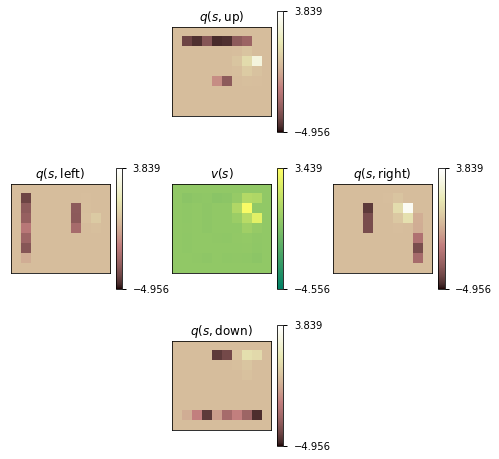

In [ ]:
# Online Q
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

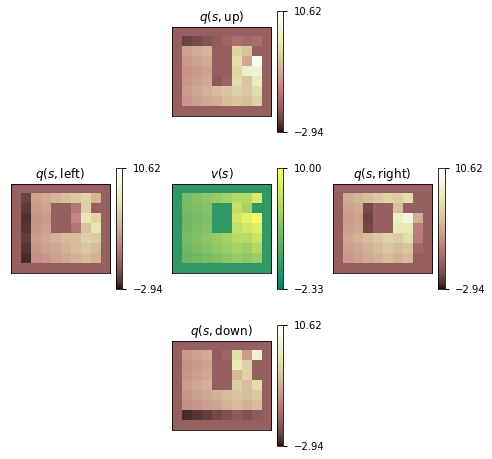

In [ ]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

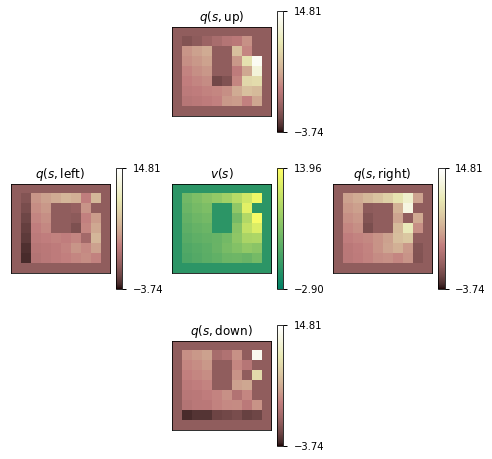

In [ ]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Q 1.3.1 [3 marks]

In the experiments above, how do the learnt value estimates differ between the online Q-learning, ExperienceReplay, and Dyna Q agents?

Explain meaningful differences in at most 5 sentences.

> The ExperienceReplay and Dyna Q agents produce far better learnt value estimates than the online Q-learning value, shown by the Online Q-learning agent's failure to differentiate between the value of squares on and off the grid. The ExperienceReplay agent learns the value estimates much better, providing significantly higher values for squares on the grid than for those off it and providing the highest value to squares around the goal. This is because ExperienceReplay agent stores the experience separately and is able to make more efficient use of this experience by learning with it multiple times and is able to converge faster when training a function approximator. The Dyna Q agent is also much better, providing slightly higher values for squares on the grid than off it and providing the highest values for those squares nearest the goal. This is again due to Dyna Q's ability to learn from experience, as it stores both the state and action, so is able to learn faster than online Q-learning due to its ability to learn from experience.

### Run experiments matching computational cost

*Online Q-learning*

* $\text{number_of_steps}$ = $62,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

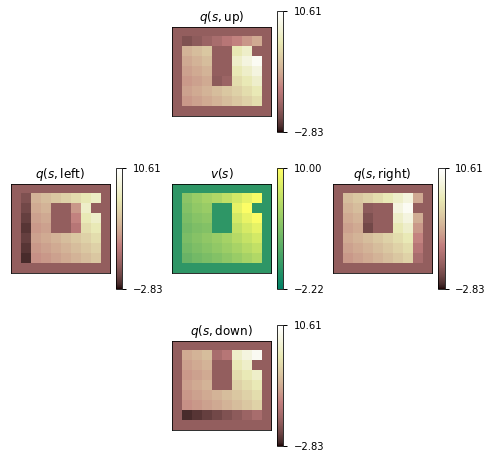

In [ ]:
# OnlineQ
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(62e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

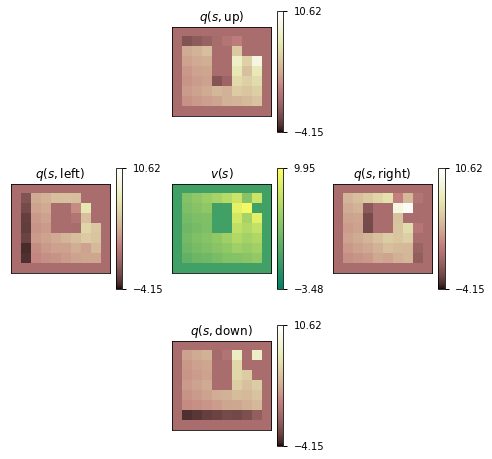

In [ ]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

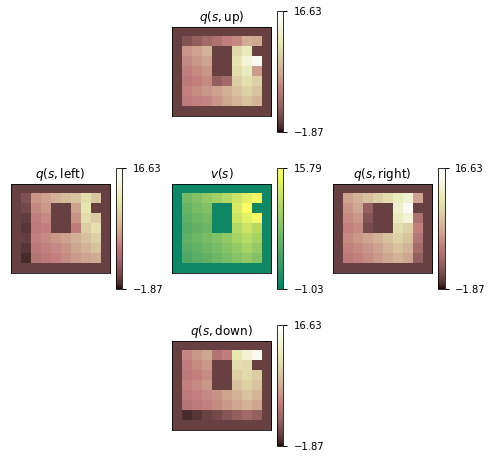

In [ ]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

What if sampling from the environment is cheap and we don't care about data efficiency but only care about the amount of computation we use? 

The experiments directly above are the same as those above question 1.3.1, except that we ran the experiments for the same number of **total updates**, rather than the same number of **steps in the environment**, therefore using more data for the online Q-learning algorithm which *only* updates from real data.

Q 1.3.2 [3 marks]

How do the learnt values, and the relative performances, change, compared to the experiment above question 1.3.1?  Explain in at most 5 sentences.

> The learnt values and relative performances change such that Online Q-Learning is much improved since it has much more real data to learn from than ExperienceReplay or Dyna Q. The relative performances and learnt values of the ExperienceReplay and Dyna Q agents do not change with respect to the previous experiment, since the previous experiment also consisted of 2000 steps and 30 offline updates. However, since the Online Q-Learning agent carrys out 62000 steps instead of just 2000, it is able to improve its learnt values and relative performance as it is able to learn from much more real data.

### Run experiments with linear function approximation

We will now use the $\text{FeatureGrid}$ domain, and consider the same 3 algorithms in the context of linear function approximation.

*Online Q-learning*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

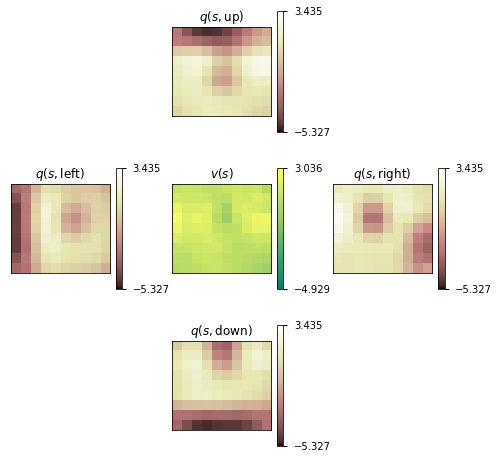

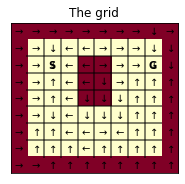

In [ ]:
# OnlineQ
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

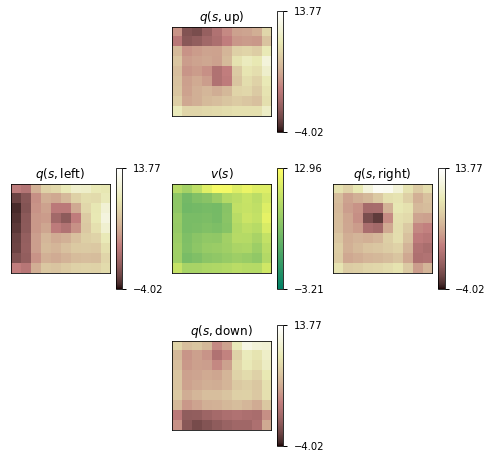

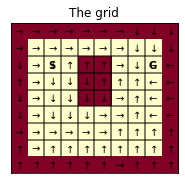

In [ ]:
# Experience Replay
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

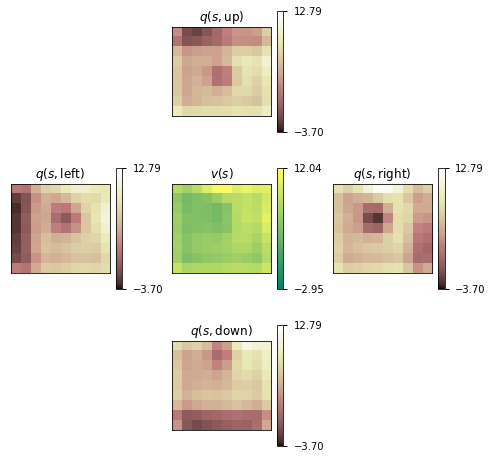

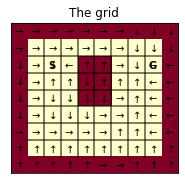

In [ ]:
# LinearDynaQ
grid = FeatureGrid()

agent = LinearDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

### Q 1.3.3 [3 marks]

How do the value estimates learnt with function approximation differ from those learnt in the tabular setting, as in the experiment above question 1.3.2?

Explain the results in at most 5 sentences.

> The value estimates learnt with the function approximation are far less exact and accurate than those learnt from the tabular, due to it being an approximation of the functions. This is to be expected as the tabular model is more exact and works efficiently for simple models, however it suffers from the curse of dimensionality when expanded to larger state spaces. Even with 100,000 steps, the Online Q-Learning agent only learns a very small value increase for the goal location and start location, with a low value learnt for the middle hole. The Linear Experience Q agent learns the value of the goal location well like the Experience Replay agent, but places a high value along the top edge which has a low reward, where the Experience Replay agent places a low value. The Linear Dyna Q agent again learns the value of the goal location well like the Dyna Q agent, but places a high value along the top edge which has a low reward, where the Dyna Q agent places a low value.

### Q 1.3.4 [3 marks]

Inspect the policies derived by training agents with linear function approximation on `FeatureGrid'. 

How do they compare to the optimal policy?

> The policies derived however are much better than the values learnt, with the Linear Experience Q and Linear Dyna Q producing policies that will most likely take you from the start to the goal. The Online Q-Learning agent produces a policy which is symmetric in that it leads from the start back to the start, unless you are on the other side of the middle hole, in which case you will be led to the goal. The policies derived from the Linear Experience Q and the Linear Dyna Q agent are very close to the optimal policy, the only significant difference being that the square to the left of the goal should have a right arrow back to the goal.  

### Run experiments in a non stationary environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left - refer to "Show gridworlds"). The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

*Online Q-learning*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$, and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

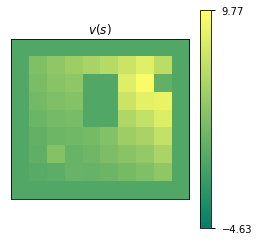

In [ ]:
# Online Q

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

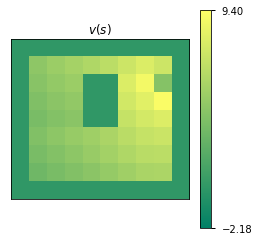

In [ ]:
# Experience Replay

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

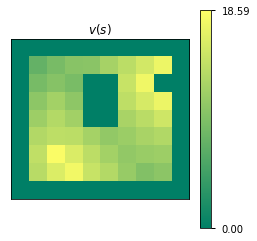

In [ ]:
# DynaQ

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

### Q 1.3.5 [3 marks]

Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location. 

Explain what you see in at most 5 sentences. 

> The value estimates of the Online Q-learning and Dyna Q agents differ significantly as the Online Q-learning agent is slower to react to the new goal location than the Dyna Q agent. Firstly with only 20,000 pretraining steps, the Online Q-Learning agent is unable to obtain very good learnt value estimates with the original goal location and this slow learning rate is shown by only a small increase in value for the new goal location. The Dyna Q agent however learns the values very well of the original goal location in the 20000 pretraining steps and then uses the 666 steps to learn the value estimate of the new goal location in the bottom left corner of the grid very well.

### Q 1.3.6 [3 marks]

Compare the value estimates of online Experience Replay and Dyna-Q, after training also on the new goal location.

Explain what you see in at most 5 sentences. 

> Again the value estimates of the Experience Replay and Dyna-Q agents differ significantly, as the Experience Replay agent fails to learn the new goal location compared to the Dyna-Q agent. This is due to the fact that all 20,666 steps are stored in the replay buffer and when randomly sampled, it is most likely to learn from the old goal configuration. However the Dyna-Q agent overwrites the reward and next state in the model, meaning that it learns from the new goal configuration much better and faster over the 666 steps, resulting in a higher learnt value for the new goa location.


# Part 2: Deep RL [25 marks]

## 2A) Actor-critics

You are going to implement an Actor-critic agent that updates a policy parametrised as a deep neural network.

The agent learns online from a single stream of experience, updating the parametes of its policy after each transition in the environment.

### Install packages

In [ ]:
!git clone https://github.com/deepmind/bsuite.git
!pip install bsuite/
!pip install dm-haiku

Cloning into 'bsuite'...
remote: Enumerating objects: 1746, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 1746 (delta 83), reused 65 (delta 36), pack-reused 1603
Receiving objects: 100% (1746/1746), 693.08 KiB | 19.25 MiB/s, done.
Resolving deltas: 100% (1253/1253), done.
Processing ./bsuite
  Created wheel for bsuite: filename=bsuite-0.3.5-cp37-none-any.whl size=249668 sha256=0663324c6c94e7f92c07d83fe72e2bc7f71ca99dd4878f70460a9523c2f04635
  Stored in directory: /tmp/pip-ephem-wheel-cache-m705k1c8/wheels/a8/39/ce/aa00d5f213ee4ff8bb4faf9d6ff36b510dd9ecd0faa819baa1
Successfully built bsuite
     |████████████████████████████████| 286kB 7.4MB/s 


### Imports

In [ ]:
from bsuite.environments import catch

import jax
import jax.numpy as jnp
import haiku as hk

import numpy as np
import matplotlib.pyplot as plt

### Plotting

In [ ]:
def plot_learning_curve(list_of_episode_returns):
  """Plot the learning curve."""
  plt.figure(figsize=(7, 5))

  def moving_average(x, w):
      return np.convolve(x, np.ones(w), 'valid') / w

  smoothed_returns = moving_average(list_of_episode_returns, 30)
  plt.plot(smoothed_returns)

  plt.xlabel('Average episode returns')
  plt.xlabel('Number of episodes')

  ax = plt.gca()
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(True)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

### Neural networks

You will now use JAX to define a network parametrising:

* The values of each state $v_{\pi}(s)$.
* The action preferences in each state $\{p_i(s)\}_{i\in\{1, ..., |A|\}}$ (you can think of and implement the preferences $\mathbf{p}(s)$ as a vector output with $|A|$ elements).

You will use `Haiku` (https://github.com/deepmind/dm-haiku) to define the network. You will need to:
* define the forward pass of the network as some function `fn`
* Use `hk.transform(fn)` to convert this in a pair of functions (`init_net`, and `apply_net`):

The `init` function has signature `parameters = init_net(key, obs)`. 
  * takes a `jax.random.PRNGKey` and an `observation`
  * returns randomly sampled weights for the neural network.

The `apply_net` functions have signature `v, p = apply_net(parameters, key, obs)` 
  * takes the current set of `parameters`, a `jax.random.PRNGKey` and an `observation`
  * returns a scalar value `v` and a vector of preferences `p`

### Q 3.1 [3 marks]

Define the forward pass of the neural network. The network must:

* take an `observation` as input
* reshape the observation into a flat vector `flat_obs`
* compute a hidden representation `h = Relu(W.dot(flat_obs) + b)`
* compute a vector of action preferences as a linear function of `h`
* compute a scalar state value as a linear function of `h`
* return the scalar value and vector preferences.

Note:
* The hidden layer should have 50 units
* the action preferences should be a vector of 3 elements (one per each available action),
* the value should be a scalar (not a vector with one element).


In [ ]:
def forward_pass(obs):
  obs = jnp.reshape(obs, (-1,))
  hidden = hk.Linear(50)(obs)
  hidden = jax.nn.relu(hidden)
  p = hk.Linear(3)(hidden)
  v = hk.Linear(1)(hidden)
  return v.squeeze(),p
init_net, apply_net = hk.transform(forward_pass)

### Choosing actions

A critical component of an actor-critic agent is a (stochastic) policy, mapping `observations` to `actions`. 

In deep RL, this mapping is conventionally parametrised by a deep neural network.

### Q 3.2 [2 marks]

Implement a softmax policy parametrised by the neural network above (i.e., using the `apply_net` function).

The function has signature `action = softmax_policy(net_params, key, obs)`,
* Taking the current network parameters `net_params`, a JAX random `key` and the current `observation`
* Returning an `action` sampled from a softmax distribution (with temperature 1.) over the set of preferences output by the neural network.

Functions to perform random sampling in JAX (e.g. those in `jax.random`) take a random key as input, and they are deterministic function of such a key. In general, in a JAX program you will therefore need to use the `split` function to generate a new random key before every new sampling. The run loop that runs the experiment later on splits the key between consecutive calls to the `policy`. Thus you can assume that a new random `key` is provided to you on each call to the `policy`, however if you need a random key in multiple places within the `policy`, do remember to split the key before each use.

In [ ]:
@jax.jit
def softmax_policy(net_params, key, obs):
  """Sample action from a softmax policy."""
  v, p = apply_net(net_params, None, obs)
  actions = jax.nn.softmax(p)
  action = jax.random.choice(key=key, a=jnp.arange(len(p)), p=actions)
  return action

### Learning values and policies

An actor-critic agent requires to update the parameters of the network so as to simultaneously improve the value predictions and the policy.

In the next section you will define the gradient updates for each of these two components.

### Q 3.3 [3 marks]

Implement a function to compute a stochastic estimate of the policy gradient from a 1 step transition in the environment.

* You will use $R_{t+1} + \gamma v(S_{t+1})$ as an estimate of $q_{\pi}(S_t, A_t)$
* You will use $v(S_{t})$ as a baseline to reduce the variance of the updates.

The function must have signature `grads = policy_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `grads` has the same structure as `net_params`
  * as it contains an estimate of the gradient of the expected episodic return wrt to each parameter 

In [ ]:
def loss_fn(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  v_tm1, p_tm1 = apply_net(net_params, key, obs_tm1)
  v_t, p_t = apply_net(net_params, key, obs_t)
  sm = jnp.exp(p_tm1)/jnp.sum(jnp.exp(p_tm1))
  loss = jax.lax.stop_gradient(r_t + discount_t*v_t - v_tm1) * jnp.squeeze(jnp.log(sm[a_tm1.astype(int)]))
  return loss

def policy_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  grads = jax.grad(loss_fn)(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return grads

### Q 3.4 [3 marks]

Implement a function to compute a stochastic estimate of the negative gradient of the value loss:   $ L(\theta) = E_{s \sim \pi}[(v_{\theta}(s) - v_{\pi}(s))^2]$

As for the policy gradient, this must be computed from a 1 step transition in the environment, so using bootstrapping after one step.

It must have signature `neg_grads = neg_value_loss_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the current parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `neg_grads` has the same structure as `net_params`
  * as it contains a stochastic estimate of the negative gradient of the expected value prediction loss 

In [ ]:
def neg_loss_fn(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  v_tm1, p_tm1 = apply_net(net_params, key, obs_tm1)
  v_t, p_t = apply_net(net_params, key, obs_t)
  target_tm1 = r_t + discount_t * v_t
  td_error = jax.lax.stop_gradient(target_tm1) - v_tm1
  loss = -(td_error)**2
  return loss

def neg_value_loss_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  neg_grads = jax.grad(neg_loss_fn)(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return neg_grads

### Updating shared parameters

The policy gradient identifies the direction of change in the parameters that most steeply improve the policy.
The negative gradient of the value loss identifies the direction of change in the parameters that most steeply improves the value predictions.

However, note that the value and policy share some of the parameters of the network.  How do we combine the two gradient updates?

In this assignment, we will simply sum the policy and value components.
The function that combines the two gradients is implemented for you in the cell below.

In [ ]:
@jax.jit
def compute_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  k1, k2 = jax.random.split(key, 2)
  pgrads = policy_gradient(net_params, k1, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = neg_value_loss_gradient(net_params, k2, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, vg: pg + vg, pgrads, vgrads)

### Optimisation

The gradient updates are typically rescaled to avoid taking too large a step on a single update.
For instance given a candidate gradient update $\nabla$ we may update our parameters $\theta$ by;
$$\Delta \theta = \theta + \alpha * \nabla\,,$$
where $\alpha$ is a small number between 0 and 1 (e.g., $\alpha=0.01$ or $\alpha=0.001$), referred to as `step_size` or `learning_rate`

The gradients with respect to each weight of a neural network may however have very different magnitudes. This can make it hard to set a suitable learning rate $\alpha$.

In deep learning, and deep RL, we typically use adaptive learning rates, for instance by rescaling each component of the gradient using statistics tracking the typical size of the updates to that weight. Then the entire update is rescaled using a global `learning_rate` $\alpha$


### Q 3.5 [3 marks]

A popular approach to adaptive gradient rescaling was introduced by the `Adam` algorithm.
* See [Kingma et al, 2014](https://arxiv.org/abs/1412.6980) for references.

This algorithm implements the following procedure before applying each update:
* Increase an update counter $k \gets k+1$ (starting at k=0 before any updates),
* Update the first moment of each gradient component $\mu \gets (1 - \beta_1) g + \beta_1 \mu$ where $g$ is the latest stochastic gradient.
* Update the second moment of each gradient component $\nu_i = (1 - \beta_2) g_i ^ 2 + \beta_2 \nu_i $ where $g$ is the latest gradient update.
* Use the following update to update the weights:
$$\Delta w = \alpha \frac{\mu / (1 - \beta_1 ^ {k})}{\epsilon + \sqrt{\nu / (1 - \beta_2 ^ {k})}}$$
* $\alpha$ is a global `learning rate`
* $\beta_1$ and $\beta_2$ define a soft horizon for the per-weight statistics.
* $\epsilon$ makes the rescaling more robust to numerical issues.

In the next cell define a pair of functions (`opt_init`, and `opt_update`), where:

The `opt_init` function has signature `state = opt_init(params)`.
* Takes the network parameters as inputs
* Initialises an `optimiser state` holding the per weight statistics.

The `opt_update` function has signature `updates, state = opt_update(grads, state)`.
* Takes a `gradient` and an `optimisers state`,
* and returns the transformed gradient and the updated `optimiser state`.

Set the algorrithm's hyper-parameters to:
* $\beta_1=.9$ and $\beta_2=.999$, $\epsilon=1e-8$.

In [ ]:
def opt_init(params):
  mu = jax.tree_map(jnp.zeros_like, params)
  v = jax.tree_map(jnp.zeros_like, params)
  k = 0

  return mu, v, k


def opt_update(grads, state):
  mu, v, k = state
  b_1 = 0.9
  b_2 = 0.999
  epsilon = 1e-08
  alpha = 0.01

  k += 1
  mu = jax.tree_multimap(lambda x,y:b_1*x + (1-b_1)*y, mu, grads)
  v = jax.tree_multimap(lambda x,y:b_2*x + (1-b_2)*y**2, v, grads)
  mu_hat = jax.tree_multimap(lambda x: x/(1-b_1**k),mu)
  v_hat = jax.tree_multimap(lambda x: x/(1-b_2**k), v)
  updates = jax.tree_multimap(lambda mu,v: alpha*mu/(jnp.sqrt(v) + epsilon), mu_hat, v_hat)
  new_state = (mu, v, k)

  return updates, new_state

### Run experiments

Run the cell below to show the performance of the resulting agent.

You may also use this section for debugging your implementations.

Note however, that most functions are `jitted` for performance,
* either using the `@jax.jit` decorator in the function definition
* or calling explicitely `fn = jax.jit(fn)`

When jitting, the code is compiled on the first time the function is executed
* and execution is much faster on subsequent calls.
* a notable side effect is that print statements in a jitted function will only execute on the first execution of the function.
* to drop into a debugger or print on each function execution you will have to disable the `@jax.jit` annotations and jax.jit calls.

Training agent for 1500 episodes...


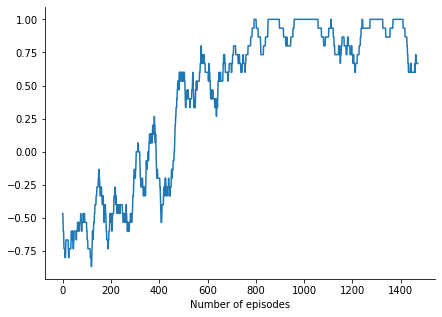

In [ ]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
net_params = init_net(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(net_params)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_multimap(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = softmax_policy(net_params, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = softmax_policy(net_params, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    rng, grad_rng = jax.random.split(rng)
    dJ_dtheta = compute_gradient(
        net_params, grad_rng, obs_tm1, a_tm1, r_t, discount_t, 
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    net_params = apply_updates(net_params, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

## 2B) An alternative update

You are going to implement a different kind of agent.

Like an actor-critic, it learns online from a single stream of experience, updating the parametes after each transition in the environment.

### Neural networks


The agent will reuse the same neural network we defined for the actor-critic:
* the scalar output will be trained via TD to estimate state values
* the vector preferences `p` will be updated according to a different rule.

### Choosing actions

As in actor-critics, the (stochastic) mapping from `observations` to `actions` depends on the vector of preferences `p` from the network.

### Q 3.6 [3 marks]

The new agent's policy will have the signature `action = epsilon_greedy_policy(net_params, key, obs)`,
* Take as inputs the current network parameters `net_params`, a JAX random `key` and the current `observation`
* Return with probability `0.9` the greedy `action` with respect to the preferences `p`, ties must be broken at random.
* Return an action uniformly at random with probability `0.1`

In [ ]:
@jax.jit
def epsilon_greedy_policy(net_params, key, obs):
  """Sample action from an epsilon-greedy policy."""
  v, p = apply_net(net_params, key, obs)
  pr = np.random.uniform()
  if pr < 0.9:
    action = jnp.argmax(p)
  else:
    action = jax.random.choice(key=key, a=np.arange(len(p)))
  return action

### Q 3.7 [4 marks]

The preferences `p` will be update according to the following gradient-based update:

* -($R_{t+1} + \gamma v(S_{t+1}) - p(S_{t}, A_t)) \nabla p(S_t, A_t))$ 
* where `v` is the state value trained by TD as in the actor critic.
* note the `-` in front of the update above.

You musy implement this in the function `preference_gradient`, with the same signature as `policy_gradient`

In [ ]:
def eps_greedy(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  v_tm1, p_tm1 = apply_net(net_params, key, obs_tm1)
  v_t, p_t = apply_net(net_params, key, obs_t)
  return -(jax.lax.stop_gradient(r_t + discount_t*v_t) - p_tm1[a_tm1.astype(int)])**2

def preference_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  return jax.grad(eps_greedy)(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t)

### Updating shared parameters

Just like in the actor critic the overall update to the parameters is a combination of two quantities:
* the new update we defined for the vector of preferences
* the same TD update to the scalar output that we used in the actor critic

In [ ]:
@jax.jit
def compute_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  k1, k2 = jax.random.split(key, 2)
  pgrads = preference_gradient(net_params, k1, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = neg_value_loss_gradient(net_params, k2, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, vg: pg + vg, pgrads, vgrads)

### Optimisation

The gradient updates are rescaled using the same optimiser used for the actor-critic.

### Run experiments

Run the cell below to show the performance of the new agent.

Training agent for 1500 episodes...


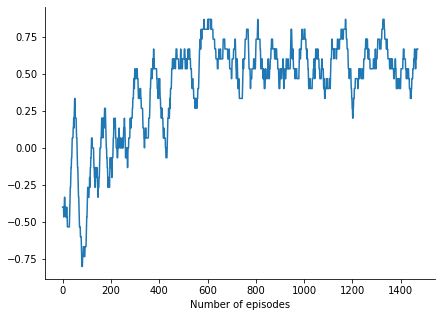

In [ ]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
net_params = init_net(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(net_params)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_multimap(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = epsilon_greedy_policy(net_params, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = epsilon_greedy_policy(net_params, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    rng, grad_rng = jax.random.split(rng)
    dJ_dtheta = compute_gradient(
        net_params, grad_rng, obs_tm1, a_tm1, r_t, discount_t, 
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    net_params = apply_updates(net_params, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

### Q 3.8 [4 marks]

[1pts]: What is the best asymptotic average return that can be achieved by the actor-critic agent described in `Part 2A)`?

> 1.0

[1pts] What is the best asymptotic average return that can be achieved by the second agent described in `Part 2B)`?

> Approximately 0.65

[2pts] What quantity do the preferences `p` estimate in the second agent described in `Part 2B)`?

> A measure of which action is preferred by the agent to potentially obtain the best reward. 

# Part 3: Off-policy multi-step learning [40 marks]

### Q4 [15 marks]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [ ]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 4.1 [7 marks]
Implement the return functions below and run the cells below that.

In [ ]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  imp = 1
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  for r in reversed(range(T)):
    imp *= pi[t]/mu[t]
    G[t] = imp*G[t]
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    rho = pi[t]/mu[t]
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = rho*(r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1]))
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    rho = pi[t]/mu[t]
    error = rho*(r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error)
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
  error = 0.
  lambdas = np.zeros((T,))
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    rho = pi[t]/mu[t]
    lmbda = l*min(1,1/rho)
    error = rho*(r[t] + d[t]*v[t + 1] - v[t] + d[t]*lmbda*error)
    errors[t] = error
    lambdas[t] = lmbda
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + lambdas*errors

In [ ]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state
  # in this case, observations are just the real states
  observations = states
  # generate rewards
  rewards = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
  # compute discounts
  discounts = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0
  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[2.03387723e+01 4.73945637e+08 1.30400029e+02 5.62889122e+00
 8.02176929e-01]


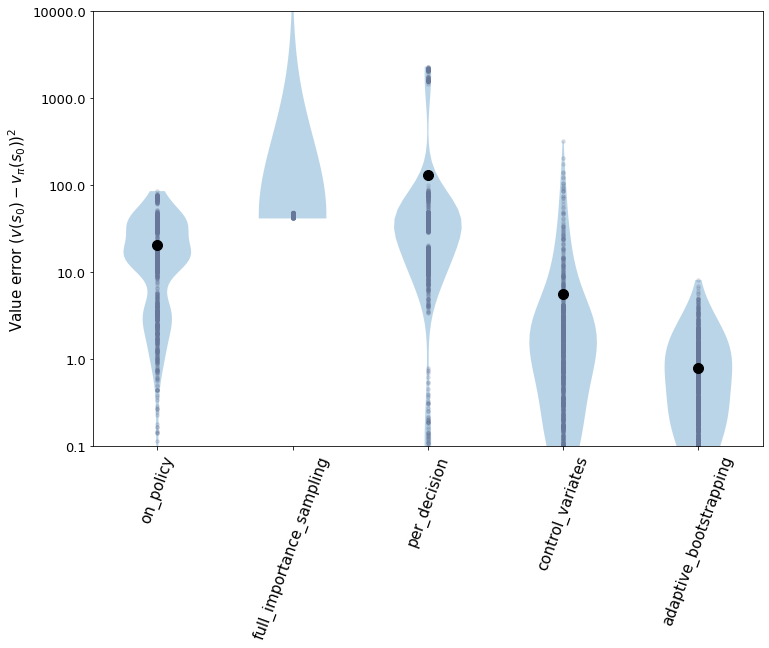

In [ ]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision',
        'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 4.2 [4 marks]
Explain the ranking in terms of value error of the different return estimates.

> The on-policy algorithm performs better than the full importance sampling algorithm due to its ability to learn from the agent's actions and due to the high variance of the importance-sampling correction. The per-decision importance weighting reduces this variance by ensuring that the expectation does not depend on the policy, so the correction is not needed, reducing the value error. Control variates can be used to further reduce variance through the addition of control variate terms, called 'error weighting', leading to an even lower value error. Adaptive bootstrapping would reduce variance even further, through picking $\lambda_t$ separately at each time step, such that $\lambda_t = min(1, 1/\rho_t)$, so that when we are too far off-policy, we truncate the sum of errors and achieve a low variance.

### Q 4.3 [4 marks]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> The best return according to this ranking would be to use Adaptive Bootstrapping, however this potentially opens us to the deadly triad when you bootstrap too much. The deadly triad refers to the possibility of divergence when combining bootstrapping, function approximation and off-policy learning. Therefore it makes sense to bootstrap adaptively only in as much as you go off-policy. is in order to improve learning without diverging in the deadly triad.


### Q5 [25 marks]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:

### Q5.1 [10 marks]
Consider a learning update based on the following temporal difference error:
    \begin{equation}
        \delta_t = r(s_{t},a_{t}) + \gamma  r(s_{t+1},a_{t+1}) + \gamma^2 \max_{a} q(s_{t+2},a) - q(s_t, a)
    \end{equation}

Consider updating a tabular action value function with TD. 
* i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 marks)

> With a finite sequence and under Robbins-Monro conditions, the resulting value function will converge if the following two conditions are met.

> - $||\mathbb{E}[F_t(x,a) |\mathscr{F_t}]|| \leq \gamma||\Delta_t||_W$, with $\gamma < 1$
- $\textbf{Var}[F_t(x,a) |\mathscr{F_t}] \leq C(1+||\Delta_t||_W^2)$, for $C > 0$

> where $\Delta_t = Q_t(x,a) - Q^*(x,a)$ and $||\mathbb{E}[F_t(x,a) |\mathscr{F_t}]|| = \sum_{s'} P_a(s,s')[r(s_t,a_t) + \gamma  r(s_{t+1},a_{t+1}) + \gamma^2 \max_{a} q(s_{t+2},a) - q(s_t, a)] = (\textbf{H}q_t)(s,a) - q^*(s,a)$, provided that $\textbf{H}$ is a $\gamma$-contraction operator.

> We can prove that $\textbf{H}$ is a $\gamma$-contraction:

> $||\textbf{H}q_1 - \textbf{H}q_2||_\infty = \sum_{s'} P_a(s,s')[r(s_t,a_t) + \gamma  r(s_{t+1},a_{t+1}) + \gamma^2 \max_{a} q_1(s_{t+2},a) - r(s_t,a_t) - \gamma  r(s_{t+1},a_{t+1}) - \gamma^2 \max_{a} q_2(s_{t+2},a)]$

> $ = \sum_{s'} P_a(s,s')[\gamma^2 (\max_{a} q_1(s_{t+2},a) - \max_{a} q_2(s_{t+2},a))]$

> With some manipulation, it is possible to arrive at the result, since $\gamma \in [0,1]$:

> $||\textbf{H}q_1 - \textbf{H}q_2||_\infty = max_{s,a} \gamma^2 \sum_{s'} P_a(s,s')||q_1 - q_2||_\infty = \gamma^2||q_1 - q_2||_\infty \leq \gamma||q_1 - q_2||_\infty$

> Therefore:

> $||\textbf{H}Q - \textbf{H}Q^*||_\infty = \gamma^2||Q - Q^*||_\infty \leq \gamma||Q - Q^*||_\infty$

> Following this, it can then be shown that $\textbf{Var}[F_t(x,a) |\mathscr{F_t}] \leq C(1+||\Delta_t||^2)$, for some constant $C$ as $r$ is bounded. Therefore, this value function will converge to the optimal value under any initialisation of the value function and therefore the error will converge to zero at its convergence point.

* ii) Under which conditions, would the above process converge to the optimal value function $q_*$? (3 marks)

> The above process will converge to the optimal value function $q_*$ provided the following four conditions are met:

> - The sequence set of trajectories is finite.
- $0\leq\alpha_t\leq1$, $\sum_t\alpha_t(x) = \infty$ and $\sum_t\alpha_t^2(x) < \infty$
- $||\mathbb{E}[F_t(x,a) |\mathscr{F_t}]||_W \leq \gamma||\Delta_t||_W$, with $\gamma < 1$
- $\textbf{Var}[F_t(x,a) |\mathscr{F_t}] \leq C(1+||\Delta_t||_W^2)$, for $C > 0$

### Q5.2 [15 marks]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(s_{t},a_{t}) + \gamma \frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})} \left[ r(s_{t+1},a_{t+1}) + \gamma \max_{a} q(s_{t+2},a) \right] - q(s_t, a_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be: a) $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$, b) $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (6 marks)

> Again, with a finite sequence and under Robbins-Monro conditions, the resulting value function will converge if the following two conditions are met.

> - $||\mathbb{E}[F_t(x,a) |\mathscr{F_t}]|| \leq \gamma||\Delta_t||_W$, with $\gamma < 1$
- $\textbf{Var}[F_t(x,a) |\mathscr{F_t}] \leq C(1+||\Delta_t||_W^2)$, for $C > 0$

> where $\Delta_t = Q_t(x,a) - Q^*(x,a)$ and $||\mathbb{E}[F_t(x,a) |\mathscr{F_t}]|| = \sum_{s'} P_a(s,s')[r(s_{t},a_{t}) + \gamma \frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})} \left[ r(s_{t+1},a_{t+1}) + \gamma \max_{a} q(s_{t+2},a) \right] - q(s_t, a_t)]] = (\textbf{H}q_t)(s,a) - q^*(s,a)$, provided that $\textbf{H}$ is a $\gamma$-contraction operator.

> We can prove that $\textbf{H}$ is a $\gamma$-contraction:

> $||\textbf{H}q_1 - \textbf{H}q_2||_\infty = \sum_{s'} P_a(s,s')[r(s_{t},a_{t}) + \gamma \frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})} \left[ r(s_{t+1},a_{t+1}) + \gamma \max_{a} q(s_{t+2},a) \right] - r(s_{t},a_{t}) - \gamma \frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})} \left[ r(s_{t+1},a_{t+1}) + \gamma \max_{a} q(s_{t+2},a) \right]]$

> $ = \sum_{s'} P_a(s,s')[\gamma^2 \frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})}(\max_{a} q_1(s_{t+2},a) - \max_{a} q_2(s_{t+2},a))]$

> With some manipulation, with $\pi(a|s) \in \arg\max_a q(s,a)$ and $\mu(a|s) \in \arg\max_a q(s,a)$ in a) it is possible to arrive at the result, since $\gamma \in [0,1]$ and both $\pi(a|s)$ and $\mu(a|s)$ cancel out:

> $||\textbf{H}q_1 - \textbf{H}q_2||_\infty = max_{s,a} \gamma^2 \sum_{s'} P_a(s,s')||q_1 - q_2||_\infty = \gamma^2||q_1 - q_2||_\infty \leq \gamma||q_1 - q_2||_\infty$

> Therefore:

> $||\textbf{H}Q - \textbf{H}Q^*||_\infty = \gamma^2||Q - Q^*||_\infty \leq \gamma||Q - Q^*||_\infty$

> In case b) however, where $\mu(a|s) = \frac{1}{|\mathcal{A}|}$, the above inequality does not hold, since the fraction $\pi(a|s)/\mu(a|s)$ is not equal to 1 and so the value function will not converge in case b).

> Following from above, it can then be shown that $\textbf{Var}[F_t(x,a) |\mathscr{F_t}] \leq C(1+||\Delta_t||^2)$, for some constant $C$ as $r$ is bounded in case a). Therefore, this value function will converge to the optimal value in case a), but not in case b).

* ii) How does the variance of this update compare to the one induced by the error in Q5.1? (5 marks). 

> In a), when the target and behaviour policies are equal, the updates in Q5.1 and Q5.2 are both equivalent and on-policy. Therefore they would have the same variance.

> In b), where the target and behaviour policies are different, the update inducing the error in Q5.1 is an on-policy algorithm and the update inducing the error in Q5.2 is a per-decision importance weighting off-policy algorithm. From the violinplot in Q4, it can be seen that the on-policy algorithm produces a lower mean value error than the per-decision importance weighting off-policy algorithm. Therefore, the variance of the update in Q5.2 is larger than the variance of the update in Q5.1.

* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (4 marks)

> A behaviour policy which is not a greedy policy would not lead to $\textbf{H}$ being a $\gamma$-contraction, since both $\pi(a|s)$ and $\mu(a|s)$ depend on the next state $s'$ and therefore cannot be factorised out of the sum like $\gamma$ can. Therefore any other behaviour policy will not converge and therefore cannot reduce the variance further. In order to reduce variance, it would make sense to use Adaptive Bootstrapping with a greedy behaviour policy to reduce variance and not be open to the deadly triad. 